## Import the necessary libraries

In [ ]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

## Read the data 

In [ ]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('/content/AAPL.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [ ]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.535086,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.546385,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.442255,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.430345,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.473097,447610800
...,...,...,...,...,...,...
2022-05-20,139.089996,140.699997,132.610001,137.589996,137.589996,137194600
2022-05-23,137.789993,143.259995,137.649994,143.110001,143.110001,117726300
2022-05-24,140.809998,141.970001,137.330002,140.360001,140.360001,104132700


## Preprocess the data

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1,1))

In [ ]:
scaled_data

array([[0.00447776],
       [0.00455321],
       [0.00385789],
       ...,
       [0.76220531],
       [0.76311882],
       [0.7817313 ]])

In [ ]:
prediction_days = 60

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Build the LSTM model

In [ ]:
def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [ ]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam', 
              loss='mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 5

## Save the model

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5', 
                               verbose = 2, 
                               save_best_only = True)

model.fit(x_train, 
          y_train, 
          epochs=25, 
          batch_size = 32,
          callbacks = [checkpointer])

Epoch 1/25
96/96 [==============================] - 17s 101ms/step - loss: 0.0058
Epoch 2/25
96/96 [==============================] - 10s 100ms/step - loss: 0.0016
Epoch 3/25
96/96 [==============================] - 10s 108ms/step - loss: 0.0018
Epoch 4/25
96/96 [==============================] - 12s 121ms/step - loss: 0.0017
Epoch 5/25
96/96 [==============================] - 10s 102ms/step - loss: 0.0013
Epoch 6/25
96/96 [==============================] - 13s 132ms/step - loss: 0.0011
Epoch 7/25
96/96 [==============================] - 12s 129ms/step - loss: 0.0013
Epoch 8/25
96/96 [==============================] - 17s 180ms/step - loss: 0.0011
Epoch 9/25
96/96 [==============================] - 18s 184ms/step - loss: 0.0011
Epoch 10/25
96/96 [==============================] - 17s 173ms/step - loss: 0.0011
Epoch 11/25
96/96 [==============================] - 14s 147ms/step - loss: 0.0012
Epoch 12/25
96/96 [==============================] - 10s 100ms/step - loss: 0.0010
Epoch 13/25
9

## Predictions

In [ ]:
test_data = stock_data[dt.datetime(2019,1,1):dt.datetime.now()]

actual_prices = test_data['Close'].values

total_dataset = pd.concat((stock_data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

In [ ]:
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1] ,1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

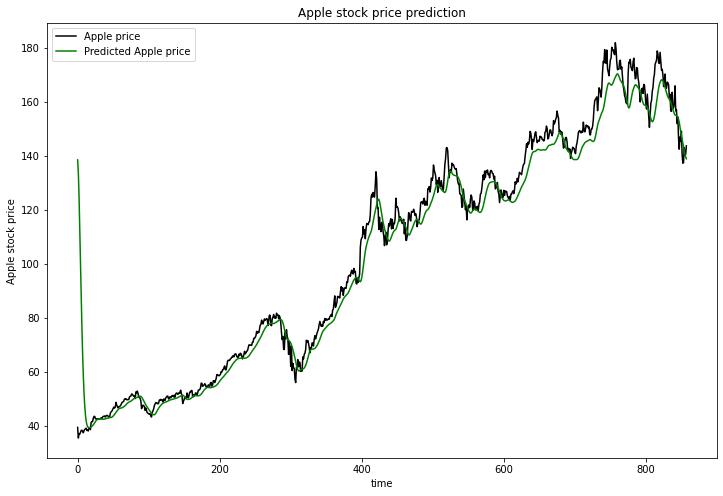

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color='black', label= "Apple price")
plt.plot(predicted_prices, color= 'green', label="Predicted Apple price")
plt.title("Apple stock price prediction")
plt.xlabel("time")
plt.ylabel("Apple stock price")
plt.legend()
plt.show()